In [51]:
from iminuit import cost, Minuit
import numpy as np
import awkward as ak
import json
import uproot
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import sys
import pickle
import math
from scipy.optimize import curve_fit
from scipy import stats
import mplhep as hep
import copy

plt.style.use(hep.style.ATLASAlt)

sys.path.append("/home/jon/work/protodune/analysis/pi0_reco/code/pi0_fitter")
import pi0fit.fitter_utilities as futil
from pi0fit.diagnostics import Diagnostics
from pi0fit.pi0_fit import Pi0Fitter

In [3]:
with open("../config.json", 'r') as f:
        config = json.load(f)

root_path = '/home/jon/work/protodune/analysis/pi0_reco/code/pi0_fitter'
config["analytic_shower_model"]["normalization_splines"] = root_path + "/etc/topo_norm_interpolation_v2.pkl"
config["binned_shower_model"]["kde_file"]= root_path + "/etc/charge_pdf_3d_TR_kde_bw0_20_50_1200.pkl"
config["binned_pi0_model"]["charge_hist_file"]= root_path + "/etc/mean_variance_hist_single_gamma_pdf_rotated_cdist_3d_wzero_50_1200.pkl"
config["binned_pi0_model"]["direction_hist_file"]= root_path + "/etc/hist_single_gamma_direction_pdf_rotated_cdist_3d.pkl"

pi0_diag = Diagnostics(config)
pi0_fitter = Pi0Fitter(config)

Loaded QHist file: /home/jon/work/protodune/analysis/pi0_reco/code/pi0_fitter/etc/mean_variance_hist_single_gamma_pdf_rotated_cdist_3d_wzero_50_1200.pkl
QHist Bins (20, 20, 20)
Loaded DirHist file: /home/jon/work/protodune/analysis/pi0_reco/code/pi0_fitter/etc/hist_single_gamma_direction_pdf_rotated_cdist_3d.pkl
DirHist Bins (40, 40, 40)
Random Hist (50, 20, 20, 20)
Loaded QHist file: /home/jon/work/protodune/analysis/pi0_reco/code/pi0_fitter/etc/mean_variance_hist_single_gamma_pdf_rotated_cdist_3d_wzero_50_1200.pkl
QHist Bins (20, 20, 20)
Loaded DirHist file: /home/jon/work/protodune/analysis/pi0_reco/code/pi0_fitter/etc/hist_single_gamma_direction_pdf_rotated_cdist_3d.pkl
DirHist Bins (40, 40, 40)
Random Hist (50, 20, 20, 20)
Loaded QHist file: /home/jon/work/protodune/analysis/pi0_reco/code/pi0_fitter/etc/mean_variance_hist_single_gamma_pdf_rotated_cdist_3d_wzero_50_1200.pkl
QHist Bins (20, 20, 20)
Loaded DirHist file: /home/jon/work/protodune/analysis/pi0_reco/code/pi0_fitter/etc/h

In [4]:
class KF:

    def __init__(self, theta0, inv_cov_matrix=None):
        self.theta0 = theta0

        if inv_cov_matrix is None:
            #cov_matrix = np.array([[0.0083, 0.0003, -0.0044],[-0.0017, 0.0037, 0.0003],[-0.0044, -0.0017, 0.1189]]) # thesis 
            #inv_cov_matrix = np.linalg.inv(cov_matrix)
            self.inv_cov_matrix = np.array([[121.28164664,  -7.76253206,   4.50772081],
                                        [ 55.29599369, 266.41814081,   1.37407006],
                                        [  5.27874209,   3.52191504,   8.59688722]])

        self.e1, self.e2, self.oa = 0, 0, 0
        self.inside_cost = None

    @staticmethod
    def invariant_mass(e1,e2,oa):
        return np.sqrt(2. * e1 * e2 * (1. - np.cos(oa)))

    def set_cost(self, inside_cost):
        self.inside_cost = inside_cost

    def test_func(self, x, e1,e2,e3,lam):
        vec1 = (np.array([e1,e2,e3]) - self.theta0)
        chi2 = lam * (e1 + e2 + e3 - 29) + vec1 @ self.inv_cov_matrix @ vec1.T
        return -chi2
        
    def kinematic_func(self, x, e1,e2,oa,lam):
        vec1 = (np.array([e1,e2,oa]) - self.theta0)
        chi2 = lam * (2. * e1 * e2 * (1. - np.cos(oa)) - 0.135*0.135) + vec1 @ self.inv_cov_matrix @ vec1.T
        
        return -chi2

    def double_kinematic_func(self, x, lam):

        m = Minuit(self.inside_cost, e1=self.theta0[0], e2=self.theta0[1], oa=self.theta0[2], lam=lam)
        # m = Minuit(self.inside_cost, e1=0.3, e2=0.2, oa=np.radians(40), lam=lam)
        m.limits["e1"] = (0.05, 1)
        m.limits["e2"] = (0.05, 1)
        m.limits["oa"] = (np.radians(10), np.radians(100))
        m.fixed["lam"] = True
        m.migrad()
        self.e1, self.e2, self.oa = m.params['e1'].value, m.params['e2'].value, m.params['oa'].value
        
        vec1 = (np.array([self.e1,self.e2,self.oa]) - self.theta0)
        chi2 = lam * (2. * self.e1 * self.e2 * (1. - np.cos(self.oa)) - 0.135*0.135) + vec1 @ self.inv_cov_matrix @ vec1.T
        
        return chi2

def toy_fit(e1, e2, e3):
    theta0 = np.array([e1, e2, e3])

    test_cov_matrix = np.array([[0.25,0,0],[0,1,0],[0,0,1]])
    test_inv_cov_matrix = np.linalg.inv(test_cov_matrix)

    fit_func = KF(theta0=theta0, inv_cov_matrix=test_inv_cov_matrix)
    c = cost.UnbinnedNLL([1], fit_func.test_func, log=True)
    
    m = Minuit(c, e1=2, e2=12, e3=14, lam=0.4)
    m.limits["e1"] = (1,20)
    m.limits["e2"] = (1,20)
    m.limits["e3"] = (1,20)
    m.limits["lam"] = (0.01, 1)
    
    m.migrad()

    return m.params['e1'].value, m.params['e2'].value, m.params['e3'].value, m.params['lam'].value, m.valid

def single_fit(e1, e2, oa):
    theta0 = np.array([e1, e2, oa])
    fit_func = KF(theta0=theta0)
    c = cost.UnbinnedNLL([1], fit_func.kinematic_func, log=True)
    
    m = Minuit(c, e1=e1, e2=e2, oa=oa, lam=150)
    m.limits["e1"] = (0.05, 1)
    m.limits["e2"] = (0.05, 1)
    m.limits["oa"] = (np.radians(10), np.radians(100))
    m.limits["lam"] = (1, 10000)
    
    m.migrad()

    print('Pre/Post Fit Inv. Mass:', fit_func.invariant_mass(e1, e2, oa)*1e3, "/", 
          fit_func.invariant_mass(m.params['e1'].value, m.params['e2'].value, m.params['oa'].value)*1e3)

    return m.params['e1'].value, m.params['e2'].value, m.params['oa'].value, m.params['lam'].value, m.valid

def double_fit(e1, e2, oa):
    theta0 = np.array([e1, e2, oa])
    
    fit_func = KF(theta0=theta0)
    c_inside = cost.UnbinnedNLL([1], fit_func.kinematic_func, log=True)
    fit_func.set_cost(inside_cost=c_inside)
    c = cost.UnbinnedNLL([1], fit_func.double_kinematic_func, log=True)
    
    m = Minuit(c, lam=200)
    m.limits["lam"] = (1, 10000)
    
    m.migrad()

    print('Pre/Post Fit Inv. Mass:', fit_func.invariant_mass(e1, e2, oa)*1e3, "/", 
          fit_func.invariant_mass(fit_func.e1, fit_func.e2, fit_func.oa)*1e3)

    return fit_func.e1, fit_func.e2, fit_func.oa, m.params['lam'].value, m.valid

def dot_product(x1, x2):
    return (x1 @ x2.T).T

def calculate_ip(event_record):
    vtx_x,vtx_y,vtx_z = event_record["reco_beam_endX"],event_record["reco_beam_endY"],event_record["reco_beam_endZ"]
    
    start_x = event_record["reco_daughter_allShower_startX"]
    start_y = event_record["reco_daughter_allShower_startY"]
    start_z = event_record["reco_daughter_allShower_startZ"]

    dir_x = event_record["reco_daughter_allShower_dirX"]
    dir_y = event_record["reco_daughter_allShower_dirY"]
    dir_z = event_record["reco_daughter_allShower_dirZ"]
    
    ip_list = []
    dist_list = []
    for xs,ys,zs,dx,dy,dz in zip(start_x, start_y, start_z, dir_x, dir_y, dir_z):
        dir_vec = np.array([xs - vtx_x, ys - vtx_y, zs - vtx_z])
        shower_dist = np.sqrt(dir_vec @ dir_vec)
        vtx_to_shower_vec = dir_vec / shower_dist
        shower_dir = np.array([dx, dy, dz])
        # ip_angle = np.arccos(dot_product(x1=shower_dir, x2=vtx_to_shower_vec))
        ip_angle = np.arccos(dot_product(x1=vtx_to_shower_vec, x2=shower_dir))

        ip_value = shower_dist * np.sin(ip_angle)
        ip_list.append(ip_value < 20.)
        dist_list.append((shower_dist > 3) & (shower_dist < 90))

    return np.asarray(ip_list), np.asarray(dist_list)

def open_angle(event_record, mask):
    dir_x1, dir_x2 = event_record["reco_daughter_allShower_dirX"][mask]
    dir_y1, dir_y2 = event_record["reco_daughter_allShower_dirY"][mask]
    dir_z1, dir_z2 = event_record["reco_daughter_allShower_dirZ"][mask]

    shower_dir1 = np.array([dir_x1, dir_y1, dir_z1])
    shower_dir2 = np.array([dir_x2, dir_y2, dir_z2])
    return np.arccos(dot_product(x1=shower_dir1, x2=shower_dir2))
    
def hit_cut(event_record):
    return event_record['reco_daughter_PFP_nHits'] > 80

def emscore_cut(event_record):
    return event_record['reco_daughter_PFP_emScore'] > 0.5
    
def shower_cuts(event_record):
    valid_ip, valid_dist = calculate_ip(event_record=event_record)
    valid_nhits = hit_cut(event_record=event_record)
    valid_emscore = emscore_cut(event_record=event_record)

    return valid_ip & valid_dist & valid_nhits & valid_emscore

def shower_correction_func(energy):
    p0, p1, p2, p3 = -0.91, 1.5, 0.06, -0.11
    return p3 + ((p0 - p3) / (1 + (energy / p2)**p1))

def corrected_shower_energy(energy):
    return energy - energy * shower_correction_func(energy=energy)

def gaussian(x, cen, wid, amp):
    return amp * np.exp(-(x-cen)**2 / (2*wid**2))

def norm_gaussian(x, cen, wid, amp):
    wid = abs(wid)
    return (1. / (wid*np.sqrt(2.*np.pi)))  * np.exp(-(x-cen)**2 / (2*wid**2))
    
def fit_gaussian_width(hist, bin_edges, label, color, height_frac, text_y, down=-1, up=1, reduc_div=1):
    half_height_mask = hist >= np.max(hist) * height_frac
    #print(half_height_mask)
    
    # Fit the histogram data with the Gaussian function
    bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
    popt, pcov = curve_fit(gaussian, bin_centers[half_height_mask], hist[half_height_mask]/np.max(hist[half_height_mask]))
    print("μ", popt[0], "σ", popt[1])
    
    #x = np.linspace(np.min(bin_centers[half_height_mask]),np.max(bin_centers[half_height_mask]),np.count_nonzero(half_height_mask))
    # x = np.linspace(np.min(bin_centers[half_height_mask]),np.max(bin_centers[half_height_mask]), 200)
    x = np.linspace(down,up, 200)
    y = norm_gaussian(x, *popt) / reduc_div
    plt.plot(x, y, linestyle='--', label=label, color=color)
    plt.text(0.1, text_y, label + "  $\\mu$ = " + str(round(popt[0], 4)) + "  $\\sigma$ = " + str(round(popt[1], 4)), color=color, fontsize=12)


In [5]:
# 1GeV events
# file_name_pdspana_new = "/home/jon/work/protodune/analysis/pi0_reco/data/1gev_ana_files/subset*/pduneana_*.root:pduneana/beamana"

# 2GeV events
# file_name_pdspana_new = "/home/jon/work/protodune/analysis/pi0_reco/data/2gev_ana_files/subset*/pduneana_*.root:pduneana/beamana"
file_name_pdspana_new = "/nfs/disk1/users/jon/custom_ntuples/mc/pi0_reco*/pduneana_*.root:beamana"


pdspana_branch = ["event", "run", "subrun", "reco_beam_startX", "reco_beam_startY", "reco_beam_startZ", "reco_beam_endX","reco_beam_endY","reco_beam_endZ", 
                  "reco_beam_calo_endX","reco_beam_calo_endY","reco_beam_calo_endZ",
                  "reco_beam_calo_endDirX", "reco_beam_calo_endDirY", "reco_beam_calo_endDirZ"]

pdspana_branch += ["true_beam_PDG", "true_beam_endProcess", "true_beam_startP", "true_daughter_nPi0", "true_daughter_nPiMinus", "true_daughter_nProton", "true_daughter_nPiPlus", "true_beam_daughter_PDG",
                  "true_beam_endX_SCE", "true_beam_endY_SCE", "true_beam_endZ_SCE", "true_beam_daughter_startP", "true_beam_daughter_startPx", "true_beam_daughter_startPy",
                  "true_beam_daughter_startPz"]

pdspana_branch += ["reco_daughter_allShower_energy", "reco_daughter_allShower_startX", "reco_daughter_allShower_startY", "reco_daughter_allShower_startZ",
                  "reco_daughter_PFP_emScore", "true_beam_startP", "true_beam_endP"]

pdspana_branch += ["reco_daughter_allTrack_startX", "reco_daughter_allTrack_startY", "reco_daughter_allTrack_startZ"]
pdspana_branch += ["reco_daughter_allTrack_endX", "reco_daughter_allTrack_endY", "reco_daughter_allTrack_endZ"]
pdspana_branch += ["reco_daughter_allTrack_Theta", "reco_daughter_allTrack_Phi", "reco_daughter_allTrack_alt_len", "reco_daughter_allTrack_calibrated_dEdX_SCE"]
pdspana_branch += ["reco_daughter_allShower_dirX","reco_daughter_allShower_dirY","reco_daughter_allShower_dirZ", "reco_daughter_PFP_nHits"]
pdspana_branch += ["reco_daughter_allTrack_Chi2_proton", "reco_daughter_allTrack_Chi2_ndof", "reco_daughter_PFP_true_byHits_PDG"]
pdspana_branch += ["reco_daughter_allTrack_Chi2_pion", "reco_daughter_allTrack_Chi2_ndof_pion"]
pdspana_branch += ["true_beam_Pi0_decay_startP", "true_beam_Pi0_decay_startPx", "true_beam_Pi0_decay_startPy", "true_beam_Pi0_decay_startPz"]

# pdspana_branch += ["reco_all_spacePts_X", "reco_all_spacePts_Y", "reco_all_spacePts_Z", "reco_all_spacePts_Integral"]

has_cosmics = False

## Cosmic Stuff
if has_cosmics:
    pdspana_branch += ["cosmic_pfp_spacePts_X", "cosmic_pfp_spacePts_Y", "cosmic_pfp_spacePts_Z", "cosmic_pfp_spacePts_ID"]
    
    pdspana_branch += ["cosmic_pfp_start_X", "cosmic_pfp_start_Y", "cosmic_pfp_start_Z", "cosmic_pfp_end_X", "cosmic_pfp_end_Y", "cosmic_pfp_end_Z",
                       "cosmic_pfp_IsPrimary", "cosmic_pfp_IsClearCosmic", "cosmic_pfp_IsBeam", "cosmic_pfp_ID", "cosmic_pfp_nSpPts"]


pdspana_event_record_new = uproot.concatenate(files={file_name_pdspana_new}, expressions=pdspana_branch)


# pdspana_event_record_new["valid_true_beam_daughter"] = ((pdspana_event_record_new["true_beam_daughter_PDG"] < 2000) | (pdspana_event_record_new["true_beam_daughter_PDG"] == 2212)) & \
#                                                      (pdspana_event_record_new["true_beam_daughter_startP"] > 0.01) & (pdspana_event_record_new["true_beam_daughter_PDG"] != 111)

pdspana_event_record_new["true_cex"] = (pdspana_event_record_new["true_beam_PDG"] == 211) & (pdspana_event_record_new["true_beam_endProcess"] == "pi+Inelastic") & \
(pdspana_event_record_new["true_daughter_nPi0"] == 1) & (pdspana_event_record_new["true_daughter_nPiPlus"] == 0) & (pdspana_event_record_new["true_daughter_nPiMinus"] == 0) & (pdspana_event_record_new["true_daughter_nProton"] > 0)

pdspana_event_record_new["true_single_pi0"] = (pdspana_event_record_new["true_beam_PDG"] == 211) & (pdspana_event_record_new["true_beam_endProcess"] == "pi+Inelastic") & (pdspana_event_record_new["true_daughter_nPi0"] == 1) 

# pdspana_event_record_new["validation_candidate"] = (pdspana_event_record_new["true_beam_PDG"] == 211) & (pdspana_event_record_new["true_beam_endProcess"] == "pi+Inelastic") & \
# (pdspana_event_record_new["true_daughter_nPi0"] == 0) & (pdspana_event_record_new["true_daughter_nPiPlus"] == 0) & (pdspana_event_record_new["true_daughter_nPiMinus"] == 0) & (pdspana_event_record_new["true_daughter_nProton"] > 0)

# pdspana_event_record_new["beam_pion"] = (pdspana_event_record_new["true_beam_PDG"] == 211) & (pdspana_event_record_new["true_beam_endProcess"] == "pi+Inelastic") & \
# (pdspana_event_record_new["true_beam_endZ_SCE"] > 0.)     

# pdspana_event_record_new["true_beam_Pi0_decay_OA"] = calculate_open_angle(evt_record=pdspana_event_record_new)

print(len(pdspana_event_record_new))

124932


In [ ]:
num = len(pdspana_event_record_new)
cex_events = [i for i in range(num) if pdspana_event_record_new["true_cex",i]]
print("nCEX:", len(cex_events))
# print(cex_events)

pi0_events = [i for i in range(num) if pdspana_event_record_new["true_single_pi0",i]]
# print("nSingle π0:", len(pi0_events))

In [7]:
precut_list = []
emcut_list = []
nhitcut_list = []
distcut_list = []
ipcut_list = []
energy_list = []
true_energy_list = []
shower_count = []
open_angle_list = []

for event in cex_events:
    true_daughter_shower = pdspana_event_record_new['reco_daughter_PFP_true_byHits_PDG', event] == 22
    precut_list.append(np.count_nonzero(true_daughter_shower))
    if len(pdspana_event_record_new['reco_daughter_PFP_true_byHits_PDG', event]) < 1: 
        emcut_list.append(0)
        nhitcut_list.append(0)
        distcut_list.append(0)
        ipcut_list.append(0)
        energy_list.append([])
        true_energy_list.append(np.sum(pdspana_event_record_new['true_beam_Pi0_decay_startP', event]))
        open_angle_list.append(-1)
        continue
    valid_ip, valid_dist = calculate_ip(event_record=pdspana_event_record_new[event])
    valid_nhits = hit_cut(event_record=pdspana_event_record_new[event])
    valid_emscore = emscore_cut(event_record=pdspana_event_record_new[event])

    emcut_list.append(np.count_nonzero(true_daughter_shower & valid_emscore))
    nhitcut_list.append(np.count_nonzero(true_daughter_shower & valid_emscore & valid_nhits))
    distcut_list.append(np.count_nonzero(true_daughter_shower & valid_emscore & valid_nhits & valid_dist))
    ipcut_list.append(np.count_nonzero(true_daughter_shower & valid_emscore & valid_nhits & valid_dist & valid_ip))
    energy_list.append(pdspana_event_record_new['reco_daughter_allShower_energy', event][true_daughter_shower & valid_emscore & valid_nhits & valid_dist & valid_ip]*1.e-3)
    true_energy_list.append(np.sum(pdspana_event_record_new['true_beam_Pi0_decay_startP', event]))
    valid_shower_mask = valid_emscore & valid_nhits & valid_dist & valid_ip
    if np.count_nonzero(valid_shower_mask) == 2:
        open_angle_list.append(open_angle(event_record=pdspana_event_record_new[event], mask=valid_shower_mask))
    else:
        open_angle_list.append(-1)
precut_list = np.asarray(precut_list)
emcut_list = np.asarray(emcut_list)
nhitcut_list = np.asarray(nhitcut_list)
distcut_list = np.asarray(distcut_list)
ipcut_list = np.asarray(ipcut_list)
open_angle_list = np.asarray(open_angle_list)
true_energy_list = np.asarray(true_energy_list)

/tmp/ipykernel_1063860/1346845911.py:127: RuntimeWarning: invalid value encountered in arccos
  ip_angle = np.arccos(dot_product(x1=vtx_to_shower_vec, x2=shower_dir))
/tmp/ipykernel_1063860/1346845911.py:124: RuntimeWarning: invalid value encountered in divide
  vtx_to_shower_vec = dir_vec / shower_dist


In [8]:
two_shower_mask = ipcut_list == 2
energies = [ak.to_numpy(e) for e in energy_list if len(e) == 2]
corr_energies = [corrected_shower_energy(energy=ak.to_numpy(e)) for e in energy_list]

pi0_energy = np.asarray([np.sum(e)for e in energies])
corr_pi0_energy = np.asarray([np.sum(e) for e in corr_energies])

calc_epi0_list = []
for energy, oa, m in zip(corr_energies, open_angle_list, two_shower_mask):
    if not m: continue
    e1 = np.max(energy)
    epi = e1 + ((0.135*0.135) / (2. * e1 * (1. - np.cos(oa))))
    calc_epi0_list.append(epi)

print(len(cex_events))
print(len(corr_energies))
print(len(energies) / len(cex_events))

6745
6745
0.08673091178650852


/tmp/ipykernel_1063860/1346845911.py:159: RuntimeWarning: invalid value encountered in power
  return p3 + ((p0 - p3) / (1 + (energy / p2)**p1))


ϵ: 1 / 0.23617494440326167


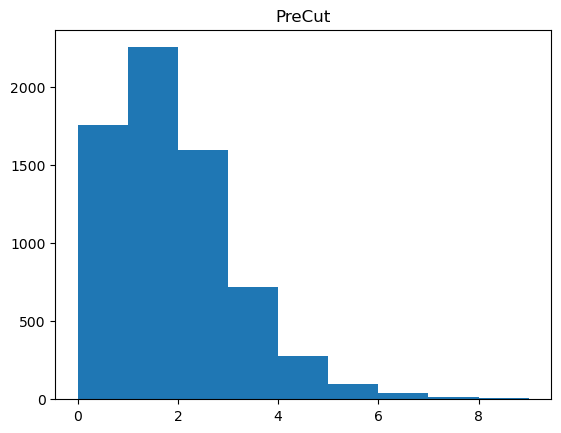

ϵ: 0.9824231010671689


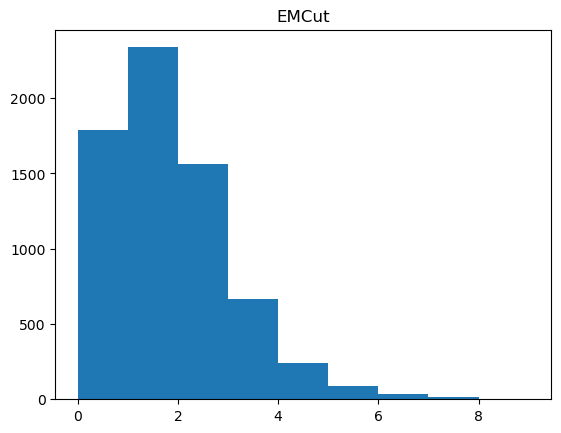

ϵ: 0.6848713119899561


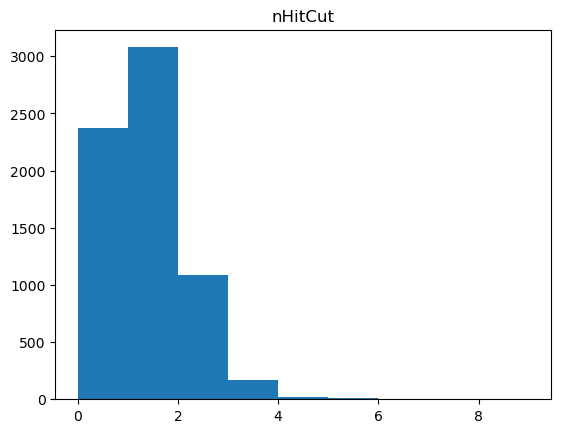

ϵ: 0.5317011927181419


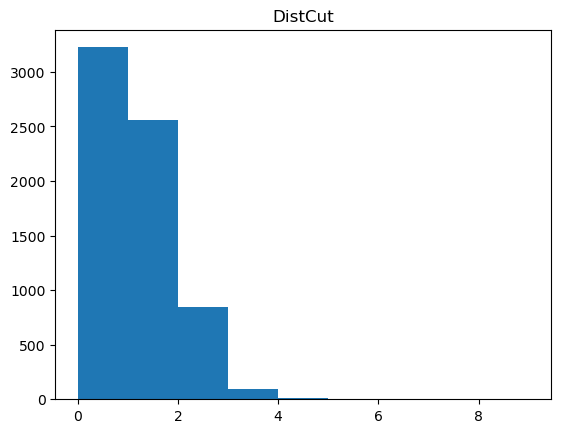

ϵ: 0.3672316384180791


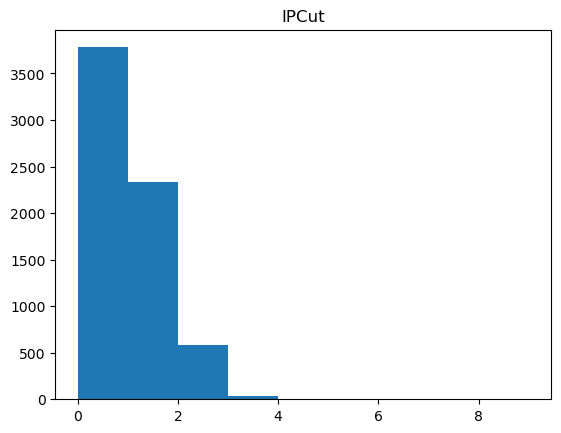

In [9]:
precut_shower_count = np.count_nonzero(precut_list == 2)
print('ϵ:', 1, "/", precut_shower_count/len(cex_events))
plt.hist(precut_list, range=[0,9], bins=9)
plt.title('PreCut')
plt.show()

print('ϵ:', np.count_nonzero(emcut_list == 2) / precut_shower_count)
plt.hist(emcut_list, range=[0,9], bins=9)
plt.title('EMCut')
plt.show()

print('ϵ:', np.count_nonzero(nhitcut_list == 2) / precut_shower_count)
plt.hist(nhitcut_list, range=[0,9], bins=9)
plt.title('nHitCut')
plt.show()

print('ϵ:', np.count_nonzero(distcut_list  == 2) / precut_shower_count)
plt.hist(distcut_list, range=[0,9], bins=9)
plt.title('DistCut')
plt.show()

print('ϵ:', np.count_nonzero(ipcut_list == 2) / precut_shower_count)
plt.hist(ipcut_list, range=[0,9], bins=9)
plt.title('IPCut')
plt.show()

In [ ]:
# single_fit
sorted_energies = [np.sort(e) for e in corr_energies if len(e) == 2]

esum_list = []
valid_list = []
trueE_list = []
for energy, oa, true_e in zip(sorted_energies, open_angle_list[two_shower_mask], true_energy_list[two_shower_mask]):
    e1, e2 = energy
    if np.isnan(e1) or np.isnan(e2) or np.isnan(oa):
        continue
    # fite1,fite2,fitoa,lam,valid_fit = single_fit(e1, e2, oa)
    fite1,fite2,fitoa,lam,valid_fit = double_fit(e1, e2, oa)
    print(valid_fit, " | ", lam)
    if not valid_fit:
        continue
    energy2 = fite1 + ((0.135*0.135) / (2. * fite1 * (1. - np.cos(fitoa))))
    esum_list.append(energy2)#fite1 + fite2)
    valid_list.append(valid_fit)
    trueE_list.append(true_e)
    

μ -0.12130690843281977 σ 0.16327536450445962
μ -0.050113658505100356 σ 0.1998267989942345
0.8871794871794871
6745
PreFit / Calc / PostFit 585 / 585 / 572


/tmp/ipykernel_1063860/1346845911.py:177: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(gaussian, bin_centers[half_height_mask], hist[half_height_mask]/np.max(hist[half_height_mask]))


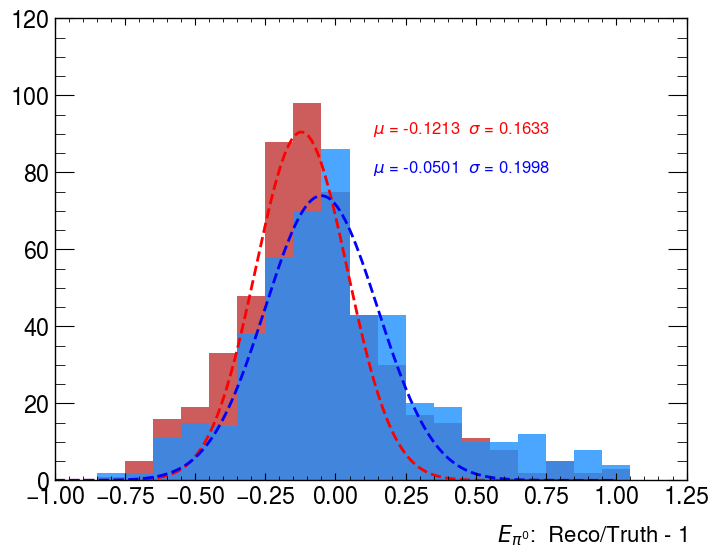

In [53]:
esum_list = np.asarray(esum_list)
trueE_list = np.asarray(trueE_list)
calc_epi0_list = np.asarray(calc_epi0_list)

# c1,bx,_=plt.hist((corr_pi0_energy[two_shower_mask]/true_energy_list[two_shower_mask]) - 1, range=[-0.975, 1.025], bins=40, density=True)
# fit_gaussian_width(hist=c1, bin_edges=bx, label='', color='blue', height_frac=0.45, text_y=2.5, down=-1, up=1)
c2,bx,_=plt.hist((calc_epi0_list/true_energy_list[two_shower_mask]) - 1, range=[-0.95, 1.05], color='indianred', bins=20, density=False)
fit_gaussian_width(hist=c2, bin_edges=bx, label='', color='red', height_frac=0.5, text_y=90.25, down=-1, up=1, reduc_div=0.027)

c3,bx,_=plt.hist((esum_list/trueE_list) - 1, range=[-0.95, 1.05], alpha=0.8, bins=20, color='dodgerblue', density=False)
fit_gaussian_width(hist=c3, bin_edges=bx, label='', color='blue', height_frac=0.5, text_y=80., down=-1, up=1, reduc_div=0.027)

print(np.sum(c2)/len(corr_pi0_energy[two_shower_mask]))
print(len(corr_pi0_energy))
print('PreFit / Calc / PostFit', len(corr_pi0_energy[two_shower_mask]), "/", len(calc_epi0_list), "/", len(esum_list))
plt.xlabel('$E_{\pi^0}$:  Reco/Truth - 1', fontsize=16)
plt.show()

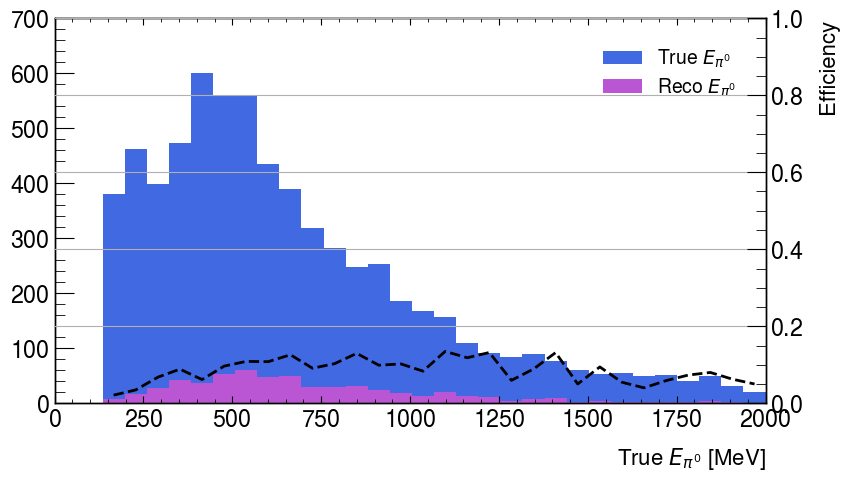

In [56]:
epi0_up = 2000

bins = 30
fig, ax1 = plt.subplots(figsize=(9,5))
c1,bx,_=ax1.hist(true_energy_list*1.e3, range=[135, epi0_up], bins=bins, color='royalblue', density=False, label='True $E_{\\pi^0}$')
c2,bx,_=ax1.hist(true_energy_list[two_shower_mask]*1.e3, range=[135, epi0_up], bins=bins, color='mediumorchid', density=False, label='Reco $E_{\\pi^0}$')
bc = (bx[0:-1] + bx[1:]) / 2.
ax1.set_xlim(0,epi0_up)
plt.legend()
ax2 = ax1.twinx()
eps = c2 / c1
ax2.plot(bc, eps, color='black', linestyle='--')
ax1.set_xlabel("True $E_{\\pi^0}$ [MeV]", fontsize=16)
ax2.set_ylabel("Efficiency", fontsize=16)
ax2.set_ylim(0,1)
plt.grid()
plt.show()


In [ ]:
idx = 5
print("Event:", cex_events[idx], "  ", pdspana_event_record_new["true_beam_Pi0_decay_startP", cex_events[idx]]*1.e3, "=", np.sum(pdspana_event_record_new["true_beam_Pi0_decay_startP", cex_events[idx]]*1.e3))
# pi0_fitter.get_event_points()
pi0_diag.show_pi0_event(event_record=pdspana_event_record_new, event=cex_events[idx], show_daughters=False, show_gammas=True, plot_axes='xz', return_precut=False)
# pi0_diag.show_pi0_event(event_record=pdspana_event_record_new, event=cex_events[idx], show_daughters=True, show_gammas=True, plot_axes='yz')

In [50]:
dist_list = []
pdg_list = []
hit_list = []
for event in cex_events:
    true_pdg = pdspana_event_record_new["reco_daughter_PFP_true_byHits_PDG", event]
    startx = pdspana_event_record_new["reco_daughter_allShower_startX", event]
    starty = pdspana_event_record_new["reco_daughter_allShower_startY", event]
    startz = pdspana_event_record_new["reco_daughter_allShower_startZ", event]
    nhit = pdspana_event_record_new["reco_daughter_PFP_nHits", event]
    
    xr = pdspana_event_record_new["reco_beam_endX", event]
    yr = pdspana_event_record_new["reco_beam_endY", event]
    zr = pdspana_event_record_new["reco_beam_endZ", event]

    for i in range(len(startx)):
        dist = np.sqrt((startx[i] - xr)**2 + (starty[i] - yr)**2 + (startz[i] - zr)**2)
        dist_list.append(dist)
        pdg_list.append(true_pdg[i])
        hit_list.append(nhit[i])

dist_list = np.asarray(dist_list)
pdg_list = np.asarray(pdg_list)
hit_list = np.asarray(hit_list)

<>:2: SyntaxWarning: invalid escape sequence '\g'
<>:10: SyntaxWarning: invalid escape sequence '\g'
<>:2: SyntaxWarning: invalid escape sequence '\g'
<>:10: SyntaxWarning: invalid escape sequence '\g'
/tmp/ipykernel_780771/111957165.py:2: SyntaxWarning: invalid escape sequence '\g'
  plt.hist(dist_list[pdg_list == 22], range=[0,100], bins=100, label='$\gamma$')
/tmp/ipykernel_780771/111957165.py:10: SyntaxWarning: invalid escape sequence '\g'
  plt.hist(hit_list[pdg_list == 22], range=[0,1000], bins=100, label='$\gamma$')


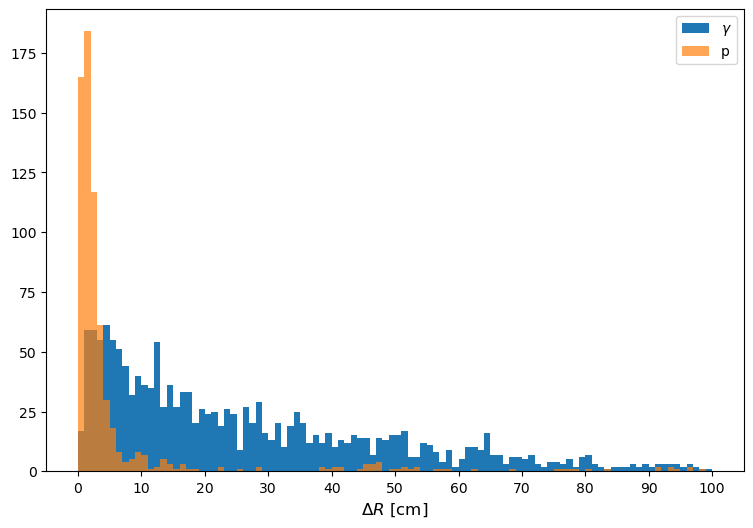

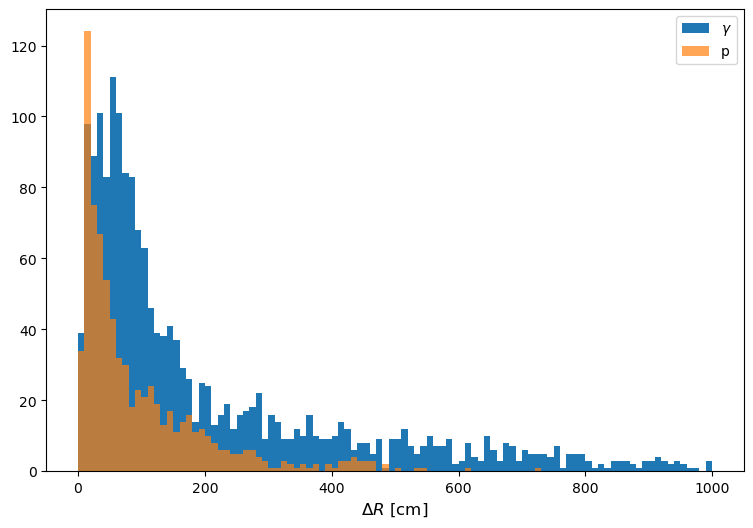

In [53]:
plt.figure(figsize=(9,6))
plt.hist(dist_list[pdg_list == 22], range=[0,100], bins=100, label='$\gamma$')
plt.hist(dist_list[pdg_list == 2212], range=[0,100], alpha=0.7, bins=100, label='p')
plt.xticks(np.arange(0, 110, 10))
plt.legend()
plt.xlabel('$\\Delta R$ [cm]', fontsize=12)
plt.show()

plt.figure(figsize=(9,6))
plt.hist(hit_list[pdg_list == 22], range=[0,1000], bins=100, label='$\gamma$')
plt.hist(hit_list[pdg_list == 2212], range=[0,1000], alpha=0.7, bins=100, label='p')
# plt.xticks(np.arange(0, 110, 10))
plt.legend()
plt.xlabel('$\\Delta R$ [cm]', fontsize=12)
plt.show()

[  0.          30.07197623  42.25679503  51.41924655  58.98500083
  65.50962484  71.27959588  76.46593913  81.18058958  85.50161179
  89.48604545  93.17708011  96.6083506   99.80665193 102.79373205
 105.5875189  108.20298593 110.65277854 112.94767748 115.09694834
 117.10860943 118.98964033 120.74614622 122.38348894 123.90639258
 125.31902926 126.62508948 127.82784005 128.93017226 129.93464188
 130.84350279 131.65873499 132.38206825 133.01500181 133.55882089
 134.01461034 134.38326589 134.66550313 134.86186463 134.97272521
 134.99829549 134.93862396 134.79359742 134.5629399  134.24620999
 133.84279667 133.35191322 132.77258948 132.10366191 131.34376149
 130.49129891 129.54444688 128.50111891 127.35894403 126.1152366
 124.76696037 123.31068532 121.74253589 120.05812839 118.25249494
 116.3199903  114.25417692 112.04768165 109.6920152  107.17734206
 104.49218307 101.623025    98.5537991   95.26517013  91.73354447
  87.92964767  83.81641793  79.34576301  74.45332442  69.04950504
  63.002857

/tmp/ipykernel_874705/3621532367.py:4: RuntimeWarning: invalid value encountered in sqrt
  f = np.sqrt(2. * e1 * (epi - e1) * (1. - np.cos(amin)))


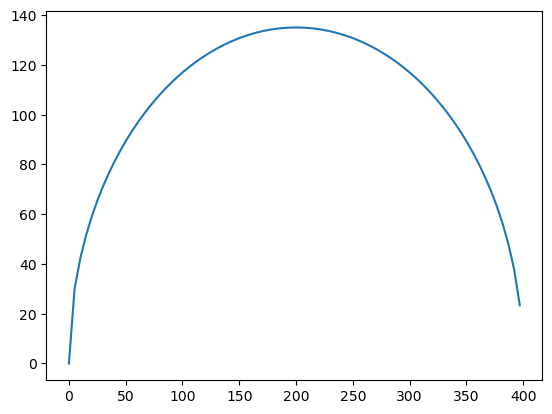

In [12]:
epi = 400
amin = 2. * np.arcsin(135. / epi)
e1 = np.linspace(0, 1000, 200)
f = np.sqrt(2. * e1 * (epi - e1) * (1. - np.cos(amin)))

plt.plot(e1, f)
print(f[~np.isnan(f)])

In [39]:
stats.distributions.chi2.sf(3,2)

0.22313016014842982

In [78]:
pval_list = []
chi2_list = []
truepdg_list = []

for event in cex_events:
    true_pdg = pdspana_event_record_new["reco_daughter_PFP_true_byHits_PDG", event]
    pchi = pdspana_event_record_new["reco_daughter_allTrack_Chi2_proton"][event]
    ndof = pdspana_event_record_new["reco_daughter_allTrack_Chi2_ndof"][event]
    for c,n,t in zip(pchi, ndof, true_pdg):
        if n < 0: continue
        pvalue = stats.distributions.chi2.sf(c,n)
        pval_list.append(pvalue)
        chi2_list.append(c/n)
        truepdg_list.append(t)

pval_list = np.asarray(pval_list)
chi2_list = np.asarray(chi2_list)
truepdg_list = np.asarray(truepdg_list)

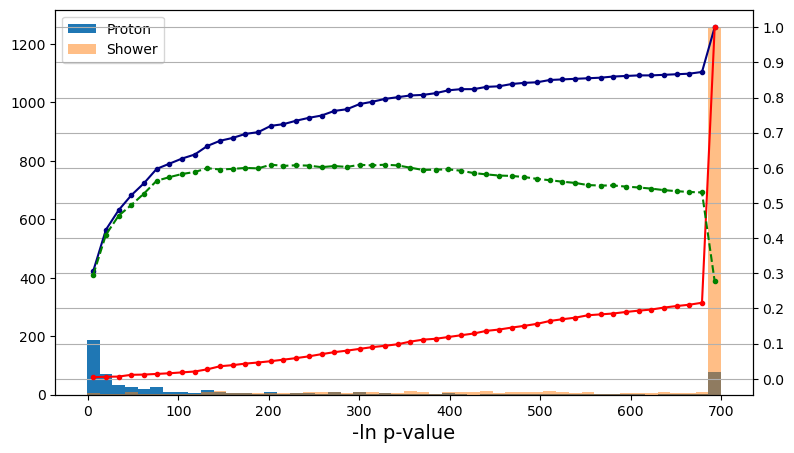

p 613.0
s 1600.0


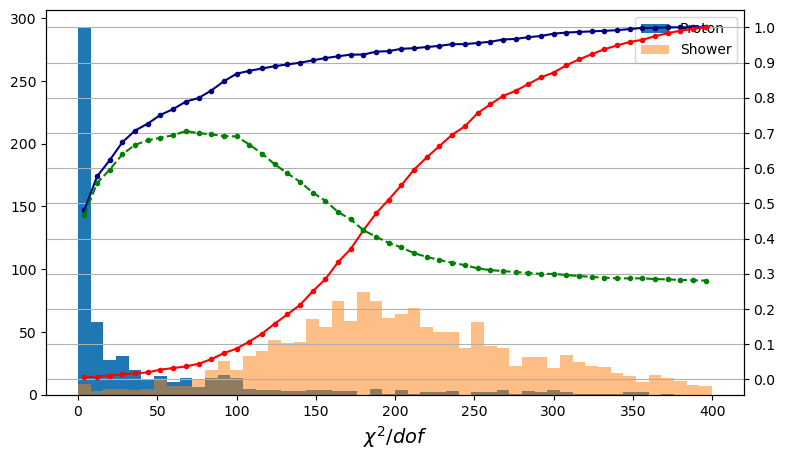

p 607.0
s 1557.0


In [104]:
pmask = truepdg_list == 2212
smask = truepdg_list == 22

fig, ax1 = plt.subplots(figsize=(9,5))

cp,b,_=ax1.hist(-np.log(pval_list[pmask] + 1.e-300), bins=50, range=[-1,700], label='Proton')
cs,b,_=ax1.hist(-np.log(pval_list[smask] + 1.e-300), bins=50, range=[-1,700], alpha=0.5, label='Shower')
ax1.set_xlabel("-ln p-value", fontsize=14)
plt.legend()
ax2 = ax1.twinx()

bc = (b[1:] + b[0:-1]) / 2.
eff,purity = np.cumsum(cp)/np.sum(cp), np.cumsum(cp) / (np.cumsum(cp) + np.cumsum(cs))
purity[np.isnan(purity)] = 0

ax2.plot(bc, np.cumsum(cp)/np.sum(cp), marker='.', color='navy')
ax2.plot(bc, np.cumsum(cs)/np.sum(cs), marker='.', color='red')
ax2.plot(bc, (eff * purity), marker='.', color='green', linestyle='--')
ax2.set_yticks(np.arange(0, 1.1, 0.1))
ax2.grid(axis='both',zorder=0)
plt.show()

print("p", np.sum(cp))
print("s", np.sum(cs))

#############################

fig, ax1 = plt.subplots(figsize=(9,5))

cp,b,_=ax1.hist(chi2_list[pmask], bins=50, range=[0,400], label='Proton')
cs,b,_=ax1.hist(chi2_list[smask], bins=50, range=[0,400], alpha=0.5, label='Shower')
ax1.set_xlabel("$\\chi^2 / dof$", fontsize=14)
plt.legend()
ax2 = ax1.twinx()

bc = (b[1:] + b[0:-1]) / 2.
eff,purity = np.cumsum(cp)/np.sum(cp), np.cumsum(cp) / (np.cumsum(cp) + np.cumsum(cs))
purity[np.isnan(purity)] = 0

ax2.plot(bc, np.cumsum(cp)/np.sum(cp), marker='.', color='navy')
ax2.plot(bc, np.cumsum(cs)/np.sum(cs), marker='.', color='red')
ax2.plot(bc, (eff * purity), marker='.', color='green', linestyle='--')
ax2.set_yticks(np.arange(0, 1.1, 0.1))
ax2.grid(axis='both',zorder=0)
plt.show()

print("p", np.sum(cp))
print("s", np.sum(cs))

# plt.hist(chi2_list[pmask], range=[0,400], bins=50)
# plt.hist(chi2_list[smask], range=[0,400], bins=50, alpha=0.8)
# plt.show()

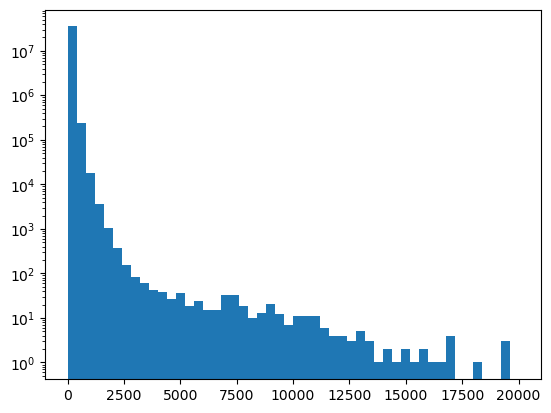

In [109]:
plt.hist(ak.ravel(pdspana_event_record_new['reco_all_spacePts_Integral'][cex_events]), range=[0,20e3], bins=50)
plt.yscale('log')
plt.show()